## This file does below:
1. Import dataset and generate/add features
2. Run different classifier models and predict the authenticity of a randomly selected article

## Import libraries and packages

In [1]:
## Import libraries & Packages

# Data structure and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import colorsys
import os
%matplotlib inline

from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB

scaler = StandardScaler(with_mean=False)

## Import data (balanced_data.csv)

In [2]:
path = os.path.join('data', 'balanced_data.csv')
total_df = pd.read_csv(path, usecols=[1,2,3,5,6])
total_df.tail()

,url,source,title,text,authenticity
2941,https://newswithviews.com/evangelicals-pray-fo...,newswithviews,Evangelicals Pray For President In W.H. – Demo...,Evangelicals Pray For President In W.H. – Demo...,1
2942,https://newswithviews.com/vaccines-good-or-bad...,newswithviews,"Vaccines: Good or Bad?, Part 8","Vaccines: Good or Bad?, Part 8\n\nThe more we ...",1
2943,https://reagancoalition.com/articles/2017/fath...,reagancoalition,Father PUNISHES 10-Year-Old Daughter by Strand...,"Christopher Charles Watson, from Kingman, Ariz...",1
2944,http://www.foxbusiness.com/features/2017/07/27...,foxnews,Delta purchases 10% stake in Air France-KLM,Delta Air Lines (DAL) and China Eastern Airlin...,0
2945,http://www.cnn.com/2016/09/08/health/rubella-h...,cnn,Can forgotten rubella children of the '60s hol...,"Brooklyn, New York (CNN) One side of the bedro...",0


## Dataset information

In [3]:
f_sites = list(set(list(total_df['source'][total_df.authenticity == 1])))
t_sites = list(set(list(total_df['source'][total_df.authenticity == 0])))
f = len(t_sites)
t = len(f_sites)

print("The number of total real news websites scraped is {} and that of fake ones is {}".format(t,f))
print('-'*100)
print("Real news websites scraped are:\n{}".format(t_sites))
print('-'*100)
print("Fake news websites scraped are:\n{}".format(f_sites))

The number of total real news websites scraped is 42 and that of fake ones is 12
----------------------------------------------------------------------------------------------------
Real news websites scraped are:
['cnn', 'npr', 'go', 'reuters', 'newyorker', 'politico', 'msnbc', 'nytimes', 'cbsnews', 'nbcnews', 'bbc', 'foxnews']
----------------------------------------------------------------------------------------------------
Fake news websites scraped are:
['bizstandardnews', 'Conservativedailypost', 'local31news', 'majorthoughts', 'Americanoverlook', 'interestingdailynews', 'donaldtrumppotus45', 'reagancoalition', 'sputniknews', 'krbcnews', 'americanfreepress', 'pamelageller', 'Bighairynews', 'openmagazines', 'president45donaldtrump', '24wpn', 'politicono', 'nbc', 'redcountry', 'aurora-news', 'ddsnewstrend', 'wordpress', 'AmericanFlavor', 'Americannews', 'ladylibertysnews', 'nephef', 'nationonenews', 'thedcgazette', 'politicalo', 'lastdeplorables', 'newsbbc', 'bipartisanreport', 'n

## Import additional features
* Author exists (1) / not exists (0)
* captital rates of title text, normalized to the average of caprate_title
* Rate of exaggerating punctuations [!,?,:,-] in title text, normalized to the average of exagg_puct_title

In [4]:
path = os.path.join('data', 'additional_features.csv')
addfeat_df = pd.read_csv(path, usecols=[1,2,3])
addfeat_df.head()

,author,caprate_title,exagg_puct_title
0,0,0.870054,0.000000
1,1,5.640481,22.393953
2,0,1.281274,0.000000
3,1,0.933102,0.000000
4,1,1.167964,0.000000


## Split the whole dataset into train, cv, test datasets 

* X_( ) = text of article body, before processed
* af_( ) = additional features, already processed
* Combining X_ and af_ first, and split the data together, and separate them again so that text can be processed separately

In [5]:
# # define training, cross-validation and testing sets

Y = total_df['authenticity']
addfeat_df['text'] = total_df.text
addfeat_df.head()
Xaf = addfeat_df
Xaf_train, Xaf_cvt, Y_train, Y_cvt = train_test_split(Xaf, Y, test_size=0.3, random_state=42)
Xaf_cv, Xaf_test, Y_cv, Y_test = train_test_split(Xaf_cvt, Y_cvt, test_size= 0.6, random_state=42)
X_train, af_train = Xaf_train.text, Xaf_train.drop('text', axis = 1)
X_cv, af_cv = Xaf_cv.text, Xaf_cv.drop('text', axis = 1)
X_test, af_test = Xaf_test.text, Xaf_test.drop('text', axis = 1)

A = X_train.shape
B = X_cv.shape
C = X_test.shape
D = af_train.shape
E = af_cv.shape
F = af_test.shape


print("Shape of X_train is {}, X_cv is {}, X_test is {}, af_train is {}, af_cv is {}, af_test is {}"
      .format(A,B,C,D,E,F))

Shape of X_train is (2062,), X_cv is (353,), X_test is (531,), af_train is (2062, 3), af_cv is (353, 3), af_test is (531, 3)


In [6]:
Y.value_counts()

1    1473
0    1473
Name: authenticity, dtype: int64

## Generate features from article body text

In [7]:
import nltk
import string
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize_stemmer(text):
    tokens = nltk.word_tokenize(text)
    # option to include punctuation or not
    #tokens = [i for i in tokens if i not in string.punctuation]
    stems = stem_tokens(tokens, stemmer)
    return stems

### Method 1: Use CountVectorizer to generate features¶

In [8]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()

In [9]:
# learn training data vocabulary, then use it to create a document-term matrix
vect.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [10]:
X_train_tot = vect.transform(X_train)
X_test_tot = vect.transform(X_test)
X_cv_tot = vect.transform(X_cv)

### Method 2: Use TF-IDF to generate features for the text body of news¶

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=tokenize_stemmer,stop_words='english',ngram_range=(1, 2))

In [12]:
tfidf.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_stemmer at 0x118cc3378>, use_idf=True,
        vocabulary=None)

In [13]:
X_train_tot = tfidf.transform(X_train)
X_test_tot = tfidf.transform(X_test)
X_cv_tot = tfidf.transform(X_cv)

X_train_tot.shape

(2062, 570026)

## Feature selection

In [14]:
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_classif, chi2, SelectFromModel

In [15]:
# select top 10% features
# selector = SelectPercentile(f_classif, percentile = 10) 

# select top 25000 features
#selector = SelectKBest(chi2, k = 10000) 


# select from model
lsvc = LinearSVC(C=9000, penalty="l1", dual=False)#.fit(X_train_tot, Y_train)
selector = SelectFromModel(lsvc, prefit=False)


selector.fit(X_train_tot, Y_train)
X_train_selected = selector.transform(X_train_tot)
X_test_selected = selector.transform(X_test_tot)
X_cv_selected = selector.transform(X_cv_tot)

print("X_train_selected shape: ", X_train_selected.shape)
print("X_test_selected shape: ", X_test_selected.shape)
print("X_cv_selected shape: ", X_cv_selected.shape)

X_train_selected shape:  (2062, 2233)
X_test_selected shape:  (531, 2233)
X_cv_selected shape:  (353, 2233)


### Obtain seleted feature names

In [16]:
# For total (w/o additional features)
feat_names_tfidf = tfidf.get_feature_names()
# For selected features (w/o additional features)
feat_names_sel = selector.transform(feat_names_tfidf)
feat_names_sel.shape

/Users/HyesooYoun/anaconda/envs/py3k/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(1, 2233)

In [17]:
feat_names_sel_list = feat_names_sel.flatten().tolist()
feat_names_sel_list[:10]

['!', '! !', '! —', '$', '$ 500', '%', '% )', '% ,', '% .', "' ."]

### Visualize top tf-idf features for each class

In [18]:
def top_tfidf_features(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_features_in_doc(x_train_dtm, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(x_train_dtm[row_id].toarray())
    return top_tfidf_features(row, features, top_n)

def top_mean_features(x_train_dtm, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = x_train_dtm[grp_ids].toarray()
    else:
        D = x_train_dtm.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_features(tfidf_means, features, top_n)

def top_features_by_class(x_train_dtm, y_train, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y_train)
    for label in labels:
        ids = np.where(y_train==label)
        features_df = top_mean_features(x_train_dtm, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        features_df.label = label
        dfs.append(features_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    width = 0.5
    fig = plt.figure(figsize=(12, 5), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean TF-IDF Score", labelpad=16, fontsize=12.5)
        ax.set_title("Class = " + str(df.label), fontsize=13.5)
        ax.ticklabel_format(axis='x', fontsize=12.5)
        ax.barh(x, df.tfidf, width, align='center', color='indigo')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature,fontsize=12.5)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.tight_layout()
    plt.savefig('./figures/topfeatures_tfidf.png', transparent=True)
    plt.show()

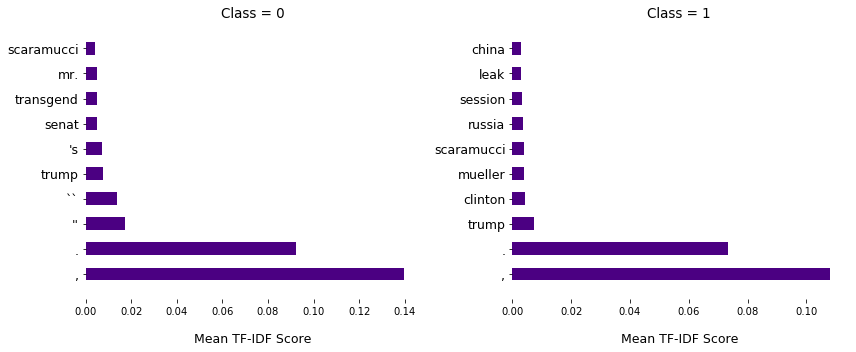

In [19]:
top_features = top_features_by_class(X_train_selected, Y_train, feat_names_sel_list,top_n=10)
plot_tfidf_classfeats_h(top_features)

## Set train, test, cv data (choose one method)

### Adding additional features

In [20]:
import scipy as sp

def concat_3features(df):
    author = np.array([[x] for x in df.author])
    caprate = np.array([[x] for x in df.caprate_title])
    exagg =  np.array([[x] for x in df.exagg_puct_title])
    return  np.concatenate((author, caprate, exagg), axis=1)

# add additional feature names
feat_names_add = ['author', 'title_capitalization', 'exclamation_in_title']

### 1. use all features

In [21]:
X_train_tot_add = sp.sparse.hstack((X_train_tot, concat_3features(af_train)))
X_cv_tot_add = sp.sparse.hstack((X_cv_tot, concat_3features(af_cv)))
X_test_tot_add = sp.sparse.hstack((X_test_tot, concat_3features(af_test)))
print("X_train_tot_add shape: ", X_train_tot_add.shape)
print("X_test_tot_add shape: ", X_test_tot_add.shape)
print("X_cv_tot_add shape: ", X_cv_tot_add.shape)

X_train_dtm = scaler.fit_transform(X_train_tot_add)
X_test_dtm = scaler.fit_transform(X_test_tot_add)
X_cv_dtm = scaler.fit_transform(X_cv_tot_add)

X_train_tot_add shape:  (2062, 570029)
X_test_tot_add shape:  (531, 570029)
X_cv_tot_add shape:  (353, 570029)


In [22]:
feat_names = feat_names_tfidf + feat_names_add 
feat_names[:10]

['!', '! !', '! #', '! $', '! %', "! '", "! ''", "! 'll", "! 'm", "! 're"]

###  2. use selected features from text body of news

In [23]:
X_train_dtm = scaler.fit_transform(X_train_selected)
X_test_dtm = scaler.fit_transform(X_test_selected)
X_cv_dtm = scaler.fit_transform(X_cv_selected)

In [24]:
feat_names = feat_names_sel_list
feat_names[:10]

['!', '! !', '! —', '$', '$ 500', '%', '% )', '% ,', '% .', "' ."]

### 3. use selected and additional features

In [25]:
X_train_sel_add = sp.sparse.hstack((X_train_selected, concat_3features(af_train)))
X_cv_sel_add = sp.sparse.hstack((X_cv_selected, concat_3features(af_cv)))
X_test_sel_add = sp.sparse.hstack((X_test_selected, concat_3features(af_test)))
print("X_train_sel_add shape: ", X_train_sel_add.shape)
print("X_test_sel_add shape: ", X_test_sel_add.shape)
print("X_cv_sel_add shape: ", X_cv_sel_add.shape)

X_train_dtm = scaler.fit_transform(X_train_sel_add)
X_test_dtm = scaler.transform(X_test_sel_add)
X_cv_dtm = scaler.transform(X_cv_sel_add)

X_train_sel_add shape:  (2062, 2236)
X_test_sel_add shape:  (531, 2236)
X_cv_sel_add shape:  (353, 2236)


In [26]:
feat_names = feat_names_sel_list + feat_names_add 
feat_names[:10]

['!', '! !', '! —', '$', '$ 500', '%', '% )', '% ,', '% .', "' ."]

## Test different machine learning classifier models

In [27]:
# validation test & Learning curve

def valid_test(model, param, param_candidates):
    
#     candidates = np.logspace(-7, 7, 10) # for alpha, C 
#     candidates = [1,2,3,4,5,6,7,8,9,10]# for integers
    train_scores, valid_scores = validation_curve(model, X_cv_dtm, Y_cv, param, param_candidates)
    avg_ts, avg_vs = train_scores.mean(axis = 1), valid_scores.mean(axis = 1)
    sd_ts, sd_vs = train_scores.std(axis = 1), valid_scores.std(axis = 1)
    vs_max_ix = np.argmax(avg_vs)
    best = param_candidates[vs_max_ix]
    print('The best {} value for {} is {}'.format(param, model, best))
    plt.figure(figsize=(10, 6))
    plt.ylim([0,1.1])
    plt.title('Validation Test')
    plt.ylabel('Scores')
    plt.xlabel('Candidate {} index'.format(param))
    plt.plot(range(10), avg_ts, label = 'Training Scores')
    plt.plot(range(10), avg_vs, label = 'Cross validation Scores')
    plt.legend(loc = 'best')
    return best

def Learning_curve(model):
    train_sizes = [50,100,150,200,250,300,350,400]
    train_sizes, train_scores, test_scores = learning_curve(model, X_train_dtm, Y_train, train_sizes=train_sizes)   
    train_scores_mean, test_scores_mean = train_scores.mean(axis = 1), test_scores.mean(axis = 1)
    train_scores_std, test_scores_std = train_scores.std(axis = 1), test_scores.std(axis = 1)
    plt.figure(figsize=(10, 6))
    plt.ylim([0,1.1])
    plt.title('Learning Curve',fontsize=15)
    plt.ylabel('Scores',fontsize=13.5)
    plt.xlabel('Training Size',fontsize=13.5)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-Validation Score")
    plt.legend(loc = 'best')
    plt.savefig('./figures/learning_curve.png', transparent=True)
    plt.show()
    
def plot_roc_curve(model):
    y_pred_prob = model.predict_proba(X_test_dtm)
    fpr, tpr, thrs = roc_curve(Y_test, y_pred_prob[:,1])
        
    plt.figure(figsize=(10, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='Logistic Regression', color='darkorange',lw = 3)
    plt.xlabel('False Positive Rate',fontsize=13.5)
    plt.ylabel('True Positive Rate',fontsize=13.5)
    plt.title('ROC Curve',fontsize=15)
    plt.savefig('./figures/roc_curve.png', transparent=True)
    plt.show()
    print('AUC is {}'.format(auc(fpr, tpr)))

def plot_precision_recall(model):
    y_pred_dec = model.decision_function(X_test_dtm)
    precision, recall, thresholds = precision_recall_curve(Y_test, y_pred_dec)
    plt.figure(figsize=(10, 6))
    plt.plot([0, 1], [1, 0],'k--')
    plt.plot(recall, precision, label='Logistic Regression', color='teal',lw = 3)
    plt.xlabel('Recall',fontsize=13.5)
    plt.ylabel('Precision',fontsize=13.5)
    plt.title('Recall-Precision Curve',fontsize=15)
    plt.savefig('./figures/recall_precision_curve.png', transparent=True)
    plt.show()

def print_scores(model, y_test_pred):
    print('Train score is {}'.format(model.score(X_train_dtm, Y_train)))
    print('Test score is {}'.format(model.score(X_test_dtm, Y_test)))
    print('F1 score is {}'.format(f1_score(Y_test,y_test_pred)))
        

### 1. Logistic Regression

The best C value for LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False) is 166.81005372000593


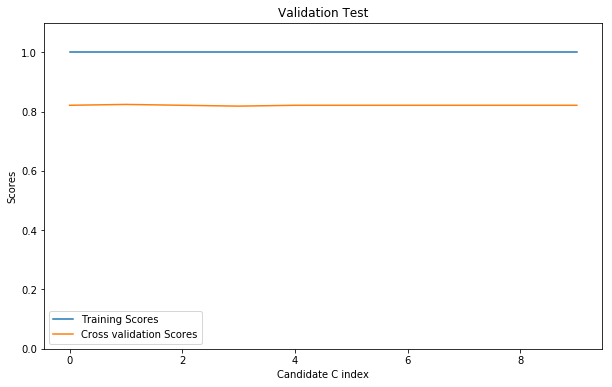

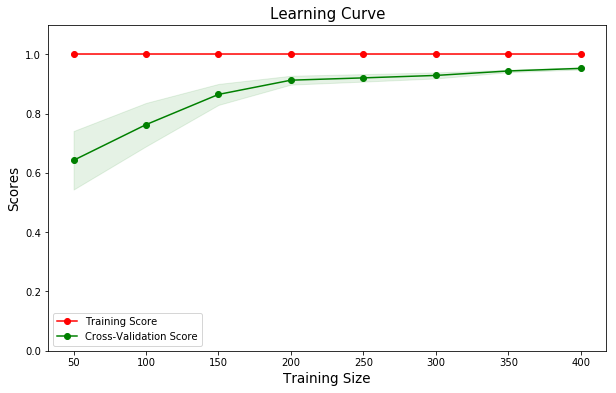

CPU times: user 202 ms, sys: 2.23 ms, total: 205 ms
Wall time: 215 ms


In [28]:
best_C = valid_test(LogisticRegression(), "C", np.logspace(2, 4, 10))
LR = LogisticRegression(C = best_C)
#LR = LogisticRegression()
Learning_curve(LR)
%time LR.fit(X_train_dtm, Y_train)
Y_test_pred_LR = LR.predict(X_test_dtm)

# polynomial_features = PolynomialFeatures(degree=2,include_bias=False)
# pipeline = Pipeline([("polynomial_features", polynomial_features), ("linear_regression", LR)])
# Learning_curve(pipeline)
# # Learning_curve(LR)

# pipeline.fit(X_train, Y_train)
# Y_test_pred_LR = pipeline.predict(X_test)
# print('Train score is {}'.format(pipeline.score(X_train, Y_train)))
# print('Cross validation score is {}'.format(pipeline.score(X_cv, Y_cv)))

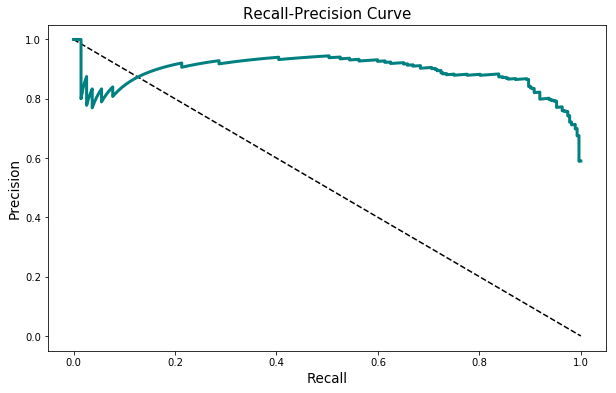

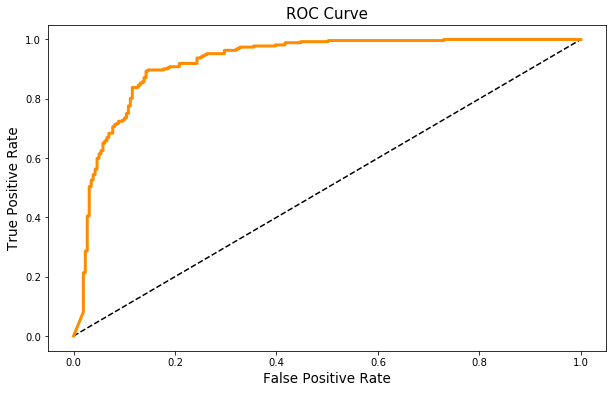

AUC is 0.9243413581648877
Train score is 1.0
Test score is 0.8436911487758946
F1 score is 0.8406909788867563


In [29]:
# plot precision recall curve
plot_precision_recall(LR)
# plot ROC curve
plot_roc_curve(LR)
# print scores
print_scores(LR, Y_test_pred_LR)

### Visualize  top features for each class using coefficients

In [30]:
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
 plt.figure(figsize=(15, 5))
 colors = ['green' if c < 0 else 'red' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], 
            rotation=60, ha='right', fontsize=12)
 plt.ylabel('Coefficient',fontsize=12)
 plt.tight_layout()
 plt.savefig('./figures/topfeatures_class.png', transparent=True)
 plt.show()

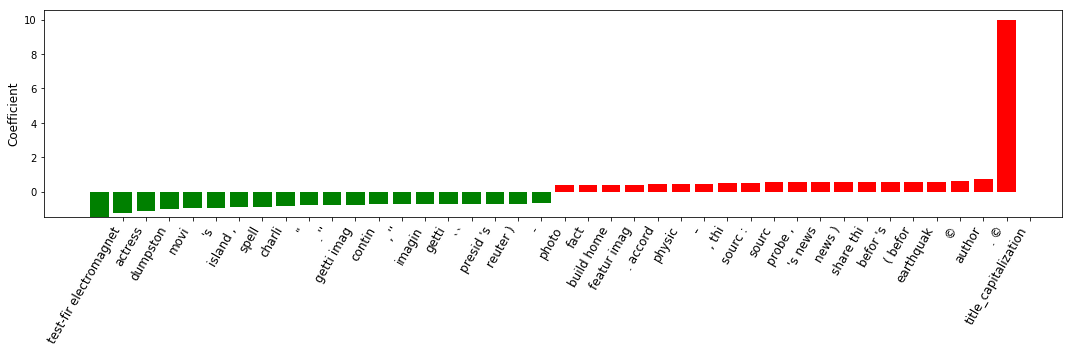

In [31]:
plot_coefficients(LR, feat_names)

### Feature importance

In [32]:
def plot_feature_importance(label):
    x = [x for x in range(LR.coef_.size)]

    LR.coef_.sort()
    y = LR.coef_
    
    f, ax = plt.subplots(1,1,figsize=(10,6))
    ax.set_xlim([0,LR.coef_.size])
    ax.set_ylabel('Coefficient',fontsize=13.5)
    ax.set_xlabel('Number of Features',fontsize=13.5)
    ax.bar(x,y[0],color='b',edgecolor='none',width=1.0)
    ax.set_title('Feature Importance',fontsize=15)
    file_name = './figures/' + label + '_feature_selection_coef.png'
    plt.savefig(file_name, transparent=True)
    plt.show

### A. before feature selection

CPU times: user 4.07 s, sys: 51 ms, total: 4.12 s
Wall time: 4.17 s


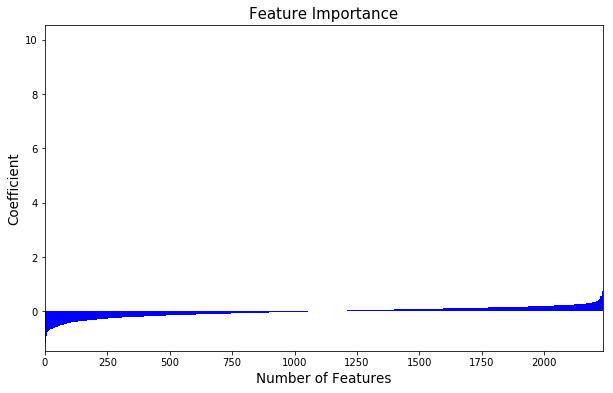

In [33]:
# too slow
%time plot_feature_importance('before')

### B. after feature selection

CPU times: user 4.44 s, sys: 34.6 ms, total: 4.48 s
Wall time: 4.55 s


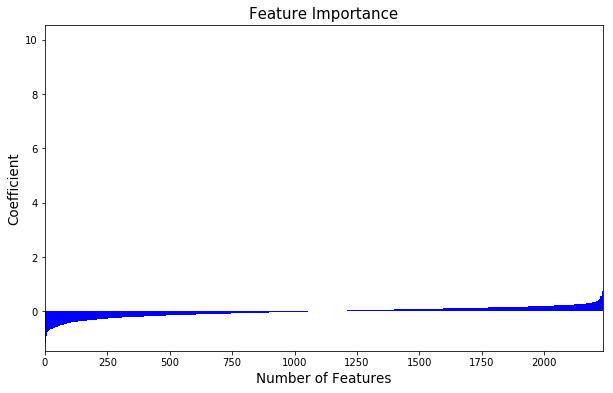

In [34]:
%time plot_feature_importance('after')

### Additional information (feature selection vs. prediction rate)

In [35]:
from sklearn import feature_selection
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

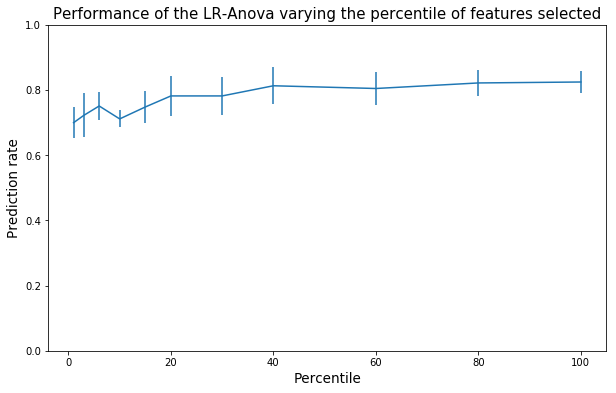

In [36]:
transform = feature_selection.SelectPercentile(feature_selection.f_classif)
clf = Pipeline([('anova', transform), ('LR', LogisticRegression(C = best_C))])

score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(clf, X_cv_dtm, Y_cv)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())
    
plt.figure(figsize=(10, 6))
plt.ylim([0,1])
plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title('Performance of the LR-Anova varying the percentile of features selected', fontsize=15)
plt.xlabel('Percentile', fontsize=13.5)
plt.ylabel('Prediction rate', fontsize=13.5)
plt.savefig('./figures/prediction_percentile.png')
plt.show()

In [37]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X_train_dtm, Y_train)
# display the relative importance of each attribute
#print(model.feature_importances_)
df = pd.DataFrame(model.feature_importances_, columns = ['importance'])
df.shape

(2236, 1)

In [38]:
model.feature_importances_

array([ 0.00279528,  0.00018429,  0.00013157, ...,  0.0003075 ,
        0.00356697,  0.00045268])

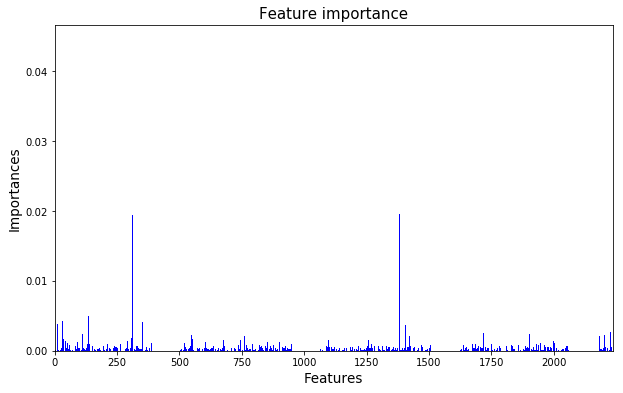

In [39]:
plt.figure(figsize=(10, 6))
plt.xlim([0,df.index.size])
plt.bar(df.index, df.importance, color="b",edgecolor='none')
plt.title('Feature importance', fontsize=15)
plt.xlabel('Features', fontsize=13.5)
plt.ylabel('Importances', fontsize=13.5)
#plt.savefig('./figures/feature_importances.png')
plt.show()

### 2. Neural networking (MLP)

The best alpha value for MLPClassifier(activation='relu', alpha=0.10000000000000001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False) is 0.03593813663804626


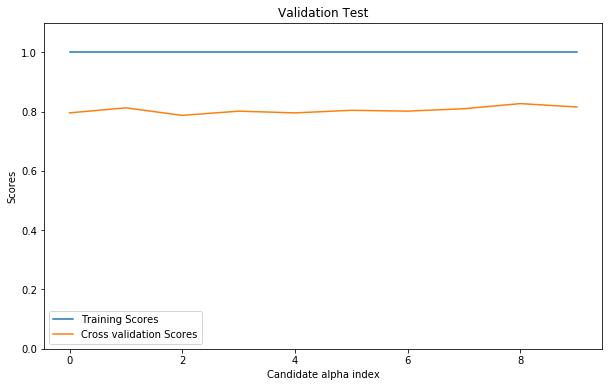

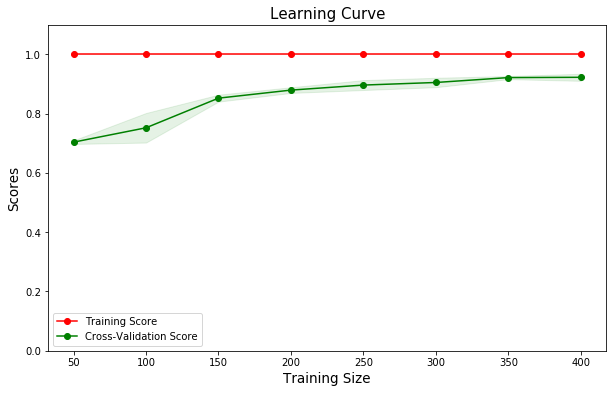

In [40]:
best_alpha = valid_test(MLPClassifier(), 'alpha', np.logspace(-5, -1, 10))
MLP = MLPClassifier(alpha=best_alpha, hidden_layer_sizes=(10, 10, 10), random_state=1, max_iter=5000)
# MLP = MLPClassifier(alpha=1e-05, hidden_layer_sizes=(12, 12, 12), random_state=1, max_iter=5000)
MLP.fit(X_train_dtm, Y_train)
Learning_curve(MLP)
Y_test_pred_MLP = MLP.predict(X_test_dtm)

# polynomial_features = PolynomialFeatures(degree=2,include_bias=False)
# pipeline = Pipeline([("polynomial_features", polynomial_features), ("MLP_Classifier", MLP)])
# pipeline.fit(X_train, Y_train)
# Learning_curve(pipeline)
# Y_test_pred_MLP = MLP.predict(X_test)

# print('train score is {}'.format(pipeline.score(X_train, Y_train)))
# print('cross validation score is {}'.format(pipeline.score(X_cv, Y_cv)))

In [41]:
# plot precision recall curve
plot_precision_recall(MLP, X_test_dtm, Y_test)
# plot ROC curve
plot_roc_curve(MLP, X_test_dtm, Y_test)
# print scores
print_scores(MLP, X_train_dtm, Y_train, X_test_dtm, Y_test, Y_test_pred_MLP)

TypeError: plot_precision_recall() takes 1 positional argument but 3 were given

### 3. Support Vector Machines

In [ ]:
best_gamma = valid_test(SVC(), "gamma", np.logspace(-5, 5, 10))
best_C = valid_test(SVC(gamma = best_gamma), "C", np.logspace(-5, 5, 10))
svm = SVC(C = best_C, gamma = best_gamma)
# svm = SVC(C = 3.6, gamma = 0.0016)
svm.fit(X_train_dtm, Y_train)
Learning_curve(svm)
Y_test_pred_svm = svm.predict(X_test_dtm)

In [ ]:
# plot precision recall curve
plot_precision_recall(svm, X_test_dtm, Y_test)
# plot ROC curve
#plot_roc_curve(svm, X_test_dtm, Y_test)
# print scores
print_scores(svm, X_train_dtm, Y_train, X_test_dtm, Y_test, Y_test_pred_svm)

### 4. RandomForestClassifier

In [ ]:
best_estimator = valid_test(RandomForestClassifier(), "n_estimators", [x for x in range(2,12)])
RF = RandomForestClassifier(n_estimators=best_estimator)
Learning_curve(RF)
%time RF.fit(X_train_dtm, Y_train)
Y_test_pred_RF = RF.predict(X_test_dtm)

In [ ]:
# RF does not have decision_function
#plot_precision_recall(RF, X_test_dtm, Y_test)

# plot ROC curve
plot_roc_curve(RF)
# print scores
print_scores(RF, Y_test_pred_RF)

### 5. naive_bayes

In [ ]:
best_alpha = valid_test(MultinomialNB(), "alpha", np.logspace(-10, 2, 10))
nb = MultinomialNB(alpha = best_alpha)
#nb = MultinomialNB()
Learning_curve(nb)
%time nb.fit(X_train_dtm, Y_train)
Y_test_pred_nb = nb.predict(X_test_dtm)    

In [ ]:
# nb does not have decision_function
#plot_precision_recall(nb)

# plot ROC curve
plot_roc_curve(nb)
# print scores
print_scores(nb, Y_test_pred_nb)